In [2]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.2 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.


In [3]:
import cv2 
import dlib
import numpy as np
from google.colab.patches import cv2_imshow
from scipy.spatial import distance
from collections import OrderedDict
import math
from imutils import paths, resize
from tqdm import tqdm
import pandas as pd
import os
import mediapipe as mp

# SUPPORT FUNCTION

In [4]:
def calculateAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [5]:
def rect_to_bb(rect):
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	return (x, y, w, h)


def shape_to_np(shape, dtype="int"):
	coords = np.zeros((68, 2), dtype=dtype)
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	return coords

In [6]:
def extractFeature(landmarksDLIB, landmarkMP):
    # D1: 
    cheek_width = distance.euclidean(landmarkMP[111], landmarkMP[340]) 

    # D2: 
    forehead_width = distance.euclidean(landmarkMP[54], landmarkMP[284])
    
    # D3: 
    face_length = distance.euclidean(landmarksDLIB[8], landmarksDLIB[-1]) 

    # D4: 
    jaw_length = distance.euclidean(landmarksDLIB[8], landmarksDLIB[13]) 

    # D5: 
    jaw_width = distance.euclidean(landmarksDLIB[3], landmarksDLIB[13]) 

    # D6: 
    chin_width1 = distance.euclidean(landmarksDLIB[6], landmarksDLIB[10]) 

    # D7: 
    chin_width2 = distance.euclidean(landmarksDLIB[7], landmarksDLIB[9]) 

    # A1: 
    angle1 = calculateAngle(landmarksDLIB[-1], landmarksDLIB[8],landmarksDLIB[10])

    # A2: 
    angle2 = calculateAngle(landmarksDLIB[-1], landmarksDLIB[8],landmarksDLIB[13])

    # A3: 
    angle3 = calculateAngle(landmarksDLIB[2], landmarksDLIB[14],landmarksDLIB[13])

    return [
        cheek_width,
        forehead_width,
        face_length,
        jaw_length,
        jaw_width,
        chin_width1,
        chin_width2,
        angle1 ,
        angle2 ,
        angle3 ,
    ]

In [7]:
def shapeRecognition(features):
    face_length = features[0]
    forehead_width = features[1]
    cheek_width = features[2]
    jaw_width = features[3]
    jaw_length = features[4]
    chin_angle = features[5]

    face_cheekbone_ratio = face_length / cheek_width

    cheek_forehead_ratio = cheek_width / forehead_width

    forehead_cheek_ratio = forehead_width / cheek_width

    forehead_jawwidth_ratio = forehead_width / jaw_width if forehead_width > jaw_width else jaw_width / forehead_width

    cheek_jaw_ratio = cheek_width / jaw_width if cheek_width > jaw_width else jaw_width / cheek_width

    totaljawline_forehead_ratio = (jaw_length*2) / forehead_width
    shape = "Inconclusive"

    if face_cheekbone_ratio >= 1.55: # OBLONG, HEART AND OVAL
        if cheek_forehead_ratio >= 1.0 and jaw_length < forehead_width:
            shape = 'Oval'
        elif forehead_width >= cheek_width and chin_angle < 100:
            shape = 'Heart'
        elif face_cheekbone_ratio <= 1.2 and forehead_jawwidth_ratio <= 1.2:
            shape = 'Oblong'
    else: # ROUND AND SQUARE
        if forehead_jawwidth_ratio <= 1.2 and cheek_forehead_ratio >= 1.0:
            shape = 'Round'
        elif forehead_cheek_ratio <= 1.2 and cheek_jaw_ratio <= 1.2 and totaljawline_forehead_ratio <= 1.3:
            shape = 'Square'
    return shape

# Face Alignment

In [8]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
	("mouth", (48, 68)),
	("inner_mouth", (60, 68)),
	("right_eyebrow", (17, 22)),
	("left_eyebrow", (22, 27)),
	("right_eye", (36, 42)),
	("left_eye", (42, 48)),
	("nose", (27, 36)),
	("jaw", (0, 17))
])

#For dlib’s 5-point facial landmark detector:
FACIAL_LANDMARKS_5_IDXS = OrderedDict([
	("right_eye", (2, 3)),
	("left_eye", (0, 1)),
	("nose", (4))
])

In [9]:
class FaceAligner:
	def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
		desiredFaceWidth=256, desiredFaceHeight=None):
		# store the facial landmark predictor, desired output left
		# eye position, and desired output face width + height
		self.predictor = predictor
		self.desiredLeftEye = desiredLeftEye
		self.desiredFaceWidth = desiredFaceWidth
		self.desiredFaceHeight = desiredFaceHeight

		# if the desired face height is None, set it to be the
		# desired face width (normal behavior)
		if self.desiredFaceHeight is None:
			self.desiredFaceHeight = self.desiredFaceWidth

	def align(self, image, gray, rect):
		# convert the landmark (x, y)-coordinates to a NumPy array
		shape = self.predictor(gray, rect)
		shape = shape_to_np(shape)
		if (len(shape)==68):
			# extract the left and right eye (x, y)-coordinates
			(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
		else:
			(lStart, lEnd) = FACIAL_LANDMARKS_5_IDXS["left_eye"]
			(rStart, rEnd) = FACIAL_LANDMARKS_5_IDXS["right_eye"]
			
		leftEyePts = shape[lStart:lEnd]
		rightEyePts = shape[rStart:rEnd]

		# compute the center of mass for each eye
		leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
		rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

		# compute the angle between the eye centroids
		dY = rightEyeCenter[1] - leftEyeCenter[1]
		dX = rightEyeCenter[0] - leftEyeCenter[0]
		angle = np.degrees(np.arctan2(dY, dX)) - 180

		# compute the desired right eye x-coordinate based on the
		# desired x-coordinate of the left eye
		desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

		# determine the scale of the new resulting image by taking
		# the ratio of the distance between eyes in the *current*
		# image to the ratio of distance between eyes in the
		# *desired* image
		dist = np.sqrt((dX ** 2) + (dY ** 2))
		desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
		desiredDist *= self.desiredFaceWidth
		scale = desiredDist / dist

		# compute center (x, y)-coordinates (i.e., the median point)
		# between the two eyes in the input image
		eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2), int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))
		# grab the rotation matrix for rotating and scaling the face
		M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

		# update the translation component of the matrix
		tX = self.desiredFaceWidth * 0.5
		tY = self.desiredFaceHeight * self.desiredLeftEye[1]
		M[0, 2] += (tX - eyesCenter[0])
		M[1, 2] += (tY - eyesCenter[1])

		# apply the affine transformation
		(w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
		output = cv2.warpAffine(image, M, (w, h),
			flags=cv2.INTER_CUBIC)

		# return the aligned face
		return output

# LANDMARK DETECTION

In [10]:
def landmarkDetectionDLIB(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('/content/drive/MyDrive/CS331/shape_predictor_68_face_landmarks.dat')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = shape_to_np(shape)
    shape = shape.tolist()
    shape.append([shape[8][0], 0])
    return shape

In [11]:
def get_unique(c):
    temp_list = list(c)
    temp_set = set()
    for t in temp_list:
        temp_set.add(t[0])
        temp_set.add(t[1])
    return list(temp_set)

In [12]:
mp_face_mesh = mp.solutions.face_mesh
connections = mp_face_mesh.FACEMESH_TESSELATION
indices = get_unique(connections)

In [13]:
def landmarkDetectionMP(image):
    d = list()
    with mp_face_mesh.FaceMesh(
        static_image_mode=False,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        for face_landmark in results.multi_face_landmarks:
            lms = face_landmark.landmark
            for index in indices:
                x  = int(lms[index].x * image.shape[1])
                y  = int(lms[index].y * image.shape[0])
                d.append([x,y])

    return d

# CODE

In [14]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/CS331/shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredFaceWidth=256)

In [15]:
image = cv2.imread('/content/drive/MyDrive/CS331/Untitled1.png')
image = resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

rects = detector(gray, 2)
maxArea = 0
maxRect = None
for rect in rects:
    (x, y, w, h) = rect_to_bb(rect)
    currArea = w*h
    if currArea > maxArea:
        maxRect = rect
        maxArea = currArea

faceAligned = fa.align(image, gray, maxRect)
landmarksDLIB = landmarkDetectionDLIB(faceAligned)
landmarksMP = landmarkDetectionMP(faceAligned)

features = extractFeature(landmarksDLIB, landmarksMP)

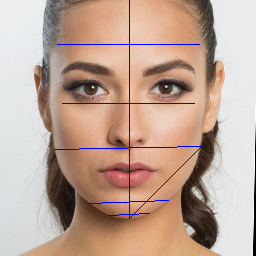

In [16]:
cv2.line(faceAligned, landmarksMP[111], landmarksMP[340], (255,0,0), 1)
cv2.line(faceAligned, landmarksMP[54], landmarksMP[284], (255,0,0), 1)

cv2.line(faceAligned, landmarksDLIB[8], landmarksDLIB[-1], (255,0,0), 1)
cv2.line(faceAligned, landmarksDLIB[8], landmarksDLIB[13], (255,0,0), 1)
cv2.line(faceAligned, landmarksDLIB[3], landmarksDLIB[13], (255,0,0), 1)
cv2.line(faceAligned, landmarksDLIB[6], landmarksDLIB[10], (255,0,0), 1)
cv2.line(faceAligned, landmarksDLIB[7], landmarksDLIB[9], (255,0,0), 1)
cv2_imshow(faceAligned)


In [17]:
shapes = []
features_ = []
labels = []

In [18]:
image_paths = list(paths.list_images('/content/drive/MyDrive/CS331/data/train'))

for path in sorted(image_paths):
    print(path)
    label = path.split(os.path.sep)[-2]
    image = cv2.imread(path)
    image = resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 2)
    maxArea = 0
    maxRect = None
    for rect in rects:
        (x, y, w, h) = rect_to_bb(rect)
        currArea = w*h
        if currArea > maxArea:
            maxRect = rect
            maxArea = currArea

    try:
      faceAligned = fa.align(image, gray, maxRect)
      landmarksDLIB = landmarkDetectionDLIB(faceAligned)
      landmarksMP = landmarkDetectionMP(faceAligned)

      features = extractFeature(landmarksDLIB, landmarksMP)
      features_.append(features)
      labels.append(label)
      # shape = shapeRecognition(features)
      # shapes.append(shape)
    except:
      pass

/content/drive/MyDrive/CS331/data/train/heart/heart (1).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (10).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (100).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (1000).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (103).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (104).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (105).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (106).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (107).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (108).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (109).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (11).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (110).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (111).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (112).jpg
/content/drive/MyDrive/CS331/data/train/heart/heart (113).jpg
/content/dr

In [19]:
import pandas as pd

In [20]:
df = pd.DataFrame(features_)
df_label = pd.DataFrame(labels)
df['label']=df_label

In [21]:
df.to_csv('/content/drive/MyDrive/CS331/features_data.csv')

In [ ]:
df.head(10)

# Visualize

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/CS331/features_data.csv')

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
data['label'] = le.fit_transform(data['label'])

In [ ]:
data_1 = data.drop(columns='label')

In [ ]:
data_1 = (data_1/500)

In [ ]:
data_1.head(10)

In [ ]:
df_norm = pd.concat((data_1, data['label']), 1)

In [ ]:
df_norm.head(10)

In [ ]:
df_norm.drop(columns='label').corrwith(df_norm['label'])

In [ ]:
df_norm.rename(columns = {'0':'face_length', '1':'cheek_width',
                              '2':'forehead_width', '3':'jaw_length', '4' : 'jaw_width', '5': 'chin_angle'} , inplace = True)

In [ ]:
df_norm = df_norm.drop(columns='cheek_jawwidth')

In [ ]:
df_norm.describe()